## Neural Network trained on MNIST Dataset

* As Colab doesn't come with keras & imgaug pre-installed, following installs those
* imgaug package is required for image Augmentation



In [0]:
# https://keras.io/
!pip install -q keras imgaug
import keras

* Import necessary modules required to build/compile/run the convolutional network



In [0]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from keras.datasets import mnist


* Load pre-shuffled MNIST data into train and test sets
* MNIST is a handwritten number dataset, which already comes with dataset divided into training & test



In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

* It is always better to play with dataset first to know more details about it
* Like below, we print the shape of the training set i.e. it shows the total count of images and the size of each image (60000, 28, 28) => 60000 images of size 28x28
* We also plot the image using matplotlib's imshow func to get a visual understanding of the dataset



(60000, 28, 28)


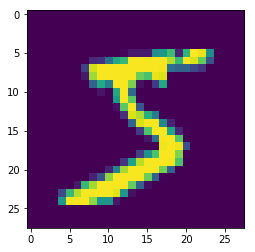

In [20]:
print (X_train.shape)
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(X_train[0])

* Lets see some more images to figure out what sort of Augmentation is required to our dataset

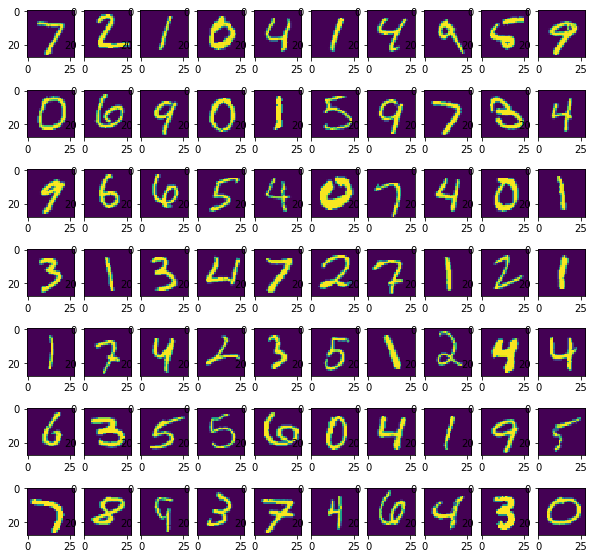

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline

w=28
h=28
fig=plt.figure(figsize=(10, 10))
columns = 10
rows = 7
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(X_test[i])
plt.show()

* Keras requires input dataset to be in a certain format i.e. it needs 3 axes to be present, 2 for size and 1 for number of channels
* Since this is a grayscale image, number of channels will be 1. And hence we use `reshape` function to add another axes
* This is done for all the data: training & test



In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

* Post Visualization here's some observation
  1. Some images have info at the border as well, hence better to keep padding for intial layer
  2. Some images are slanted (left & right), some have small patches, some look compresses and some stretched and also some are tranlated to different place (not at center). Hence we will need to use Image Augmentation to train our network with such augmented images

Original images:


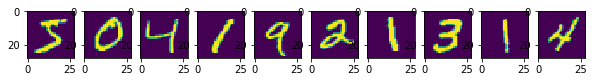

Augmented images:


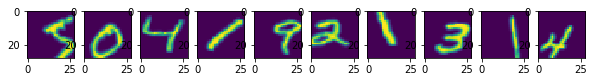

Original images:


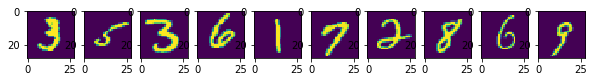

Augmented images:


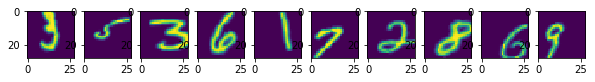

In [23]:
import numpy as np
import imgaug.augmenters as iaa

seq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-20, 20),
        shear=(-8, 8)
    ),
], random_order=True)

def view_imgs(images, rows, cols):
  w=28
  h=28
  fig=plt.figure(figsize=(10, 10))
  columns = cols
  rows = rows
  for i in range(columns*rows):
      fig.add_subplot(rows, columns, i+1)
      plt.imshow(images[i].reshape(28, 28))
  plt.show()

start_idx = 0
end_idx = 10
for batch_idx in range(2):
    test_imgs = X_train[start_idx:end_idx]
    images_aug = seq.augment_images(test_imgs)  # done by the library
    print("Original images:")
    view_imgs(test_imgs, 1, 10)
    print("Augmented images:")
    view_imgs(images_aug, 1, 10)
    start_idx = start_idx+10
    end_idx = end_idx + 10



* A neural network learns its weights by continuously adding gradient error vectors (multiplied by a learning rate) computed from backpropagation as it is trained
* With current dataset, the ranges of distribution of values will vary a lot and if they are not normalized the gradient descent algorithm will oscillate a lot to figure out better minima
* Hence, datasets are usually normalized to a smaller range. In this case, they are divided by max pixel value which is 255
* Since division is performed all values are initially converted to float



In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

* We must look at how dataset output is encoded and convert it to a format required by Keras
* As we can see below, dataset output is direct value for the image. If image is number 5, output value is 5



In [25]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

* Convert 1-dimensional class arrays to 10-dimensional class matrices
* As the network will map the input image of size 28x28x1 to an output of size 10x1, we need to encode the output values to a 10-dim class
* Each index of 10x1 array, indicates a number.
* For Ex: 5 is encoded as [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]



In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

* Here's how our output values looks like after encoding it to 10-dimensional class
* Following shows first 10 output values:



In [27]:
Y_train[:10]


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

* Following is generator code to generate augmented images
* This generator will be used by Keras to use Augmented images for training

In [0]:
import imgaug.augmenters as iaa
import random

seq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-20, 20),
        shear=(-8, 8)
    ),
])

def generator(features, labels, batch_size):  
  # Create empty arrays to contain batch of features and labels#
  batch_features = np.zeros((batch_size, 28, 28, 1))
  batch_labels = np.zeros((batch_size,10))
  while True:
    for i in range(batch_size):
      # choose random index in features
      index= random.choice(range(0, len(features)))
      batch_features[i] = features[index]
      batch_labels[i] = labels[index]
    aug_features = seq.augment_images(batch_features)
    #aug_features = batch_features
    yield aug_features, batch_labels

* We are building a Sequential network i.e. a network with sequential layers of convolution, max-pooling & activation layers
* There are no skip connections or branches involved here.
* We use max-pooling layer, to reduce the channel size. It also groups common features together. This helps greatly in reducing the number of parameters and hence making it more faster and compute efficient
* Since the output will be in matrix format, it needs to be flattened into an array, hence we use `Flatten` function
* We use `Softmax` to convert the output to probability distribution so that we get the most confident value as our output value



In [0]:
#
# Import required modules to build the network
#

from keras.layers import Activation, MaxPooling2D
model = Sequential()

 
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1)))
# Output Shape: 26x26x32
model.add(Convolution2D(10, 1, activation='relu'))
# Output Shape: 26x26x10
model.add(MaxPooling2D(2))
# 13x13x10
model.add(Convolution2D(10, 13))
# 1x1x10
model.add(Flatten())
# 1x10
model.add(Activation('softmax'))

* We have built the network, to see how our network looks, number of params required etc, we use the following function



In [0]:
model.summary()

* Above model must be compiled inorder to train our dataset
* As part of compilation we can specific how our network should be trained and how it should be interpreted
* Loss = Loss function used in backpropation
* Optimizer = Gradient Descent algorithm used in backpropagation
* Metric = Metric to be considered for evaluation network performance. In this case, `accuracy`. If we accuracy increases after each epoch then we are in right direction, if decreases then something is wrong with the network. If constant, then we con stop the training



In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [42]:
batch_size = 32
model.fit_generator(generator(X_train, Y_train, batch_size), steps_per_epoch = X_train.shape[0] / batch_size, epochs=20, validation_data=(X_test, Y_test), verbose=1)



Epoch 1/20
1875/1875 [==============================] - 46s 25ms/step - loss: 0.6930 - acc: 0.8762 - val_loss: 0.1721 - val_acc: 0.9813
Epoch 2/20
1875/1875 [==============================] - 46s 24ms/step - loss: 0.6533 - acc: 0.8863 - val_loss: 0.2014 - val_acc: 0.9819
Epoch 3/20
1875/1875 [==============================] - 46s 24ms/step - loss: 0.6680 - acc: 0.8827 - val_loss: 0.2122 - val_acc: 0.9814
Epoch 4/20
1875/1875 [==============================] - 46s 25ms/step - loss: 0.6073 - acc: 0.8950 - val_loss: 0.1953 - val_acc: 0.9825
Epoch 5/20
1875/1875 [==============================] - 46s 24ms/step - loss: 0.6388 - acc: 0.8895 - val_loss: 0.1616 - val_acc: 0.9834
Epoch 6/20
1875/1875 [==============================] - 47s 25ms/step - loss: 0.5465 - acc: 0.9073 - val_loss: 0.1773 - val_acc: 0.9828
Epoch 7/20
1875/1875 [==============================] - 46s 25ms/step - loss: 0.7098 - acc: 0.8734 - val_loss: 0.3379 - val_acc: 0.9825
Epoch 8/20
1875/1875 [==========================

* Evaluate function is used to run test data on the trained network
* And get the score of how it performed on test data


In [0]:
score = model.evaluate(X_test, Y_test, verbose=0)

* evaluate outputs two values:
  * loss value
  * accuracy
* Above shows how does the network performs on unseen data



In [0]:
print(score)

[0.05983408607971796, 0.9828]


* We can now input an unseen image to the network and see what value it predicts



In [0]:
y_pred = model.predict(X_test)

In [0]:
print(y_pred[:9])
print(y_test[:9])

[[2.0593689e-17 6.3046323e-17 8.9005447e-13 1.8406407e-10 8.0754371e-19
  8.0671096e-15 1.1510667e-24 1.0000000e+00 2.1262439e-10 2.7205176e-11]
 [2.5421015e-15 5.1460576e-12 1.0000000e+00 1.7606363e-12 6.3726551e-23
  3.3248325e-16 4.4326671e-09 1.8222993e-27 1.8873889e-12 3.6800765e-21]
 [3.7568029e-08 9.9987435e-01 6.9531761e-06 6.3134886e-10 9.9738187e-05
  5.2485571e-08 1.0483473e-07 1.0138228e-06 1.7757657e-05 1.9014761e-10]
 [1.0000000e+00 2.2739057e-15 6.6718070e-10 5.6225624e-15 4.5025926e-16
  2.7407175e-13 1.3530634e-09 3.9892802e-13 5.8574483e-14 4.0855683e-12]
 [1.0115652e-12 6.9521903e-14 1.3467061e-13 1.9833676e-13 9.9999976e-01
  4.2785103e-16 1.6022580e-12 5.5436229e-11 6.7551126e-10 2.2112354e-07]
 [2.3979660e-10 9.9982810e-01 3.5553690e-08 3.5910691e-11 1.0332796e-05
  1.4169725e-10 2.0029900e-11 1.5314015e-04 8.3647601e-06 3.8377021e-10]
 [1.4182455e-19 9.8074493e-11 5.7774190e-09 2.3251079e-13 9.9966061e-01
  6.0978769e-09 2.3871165e-16 2.2344653e-09 3.3876873e-04 

In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

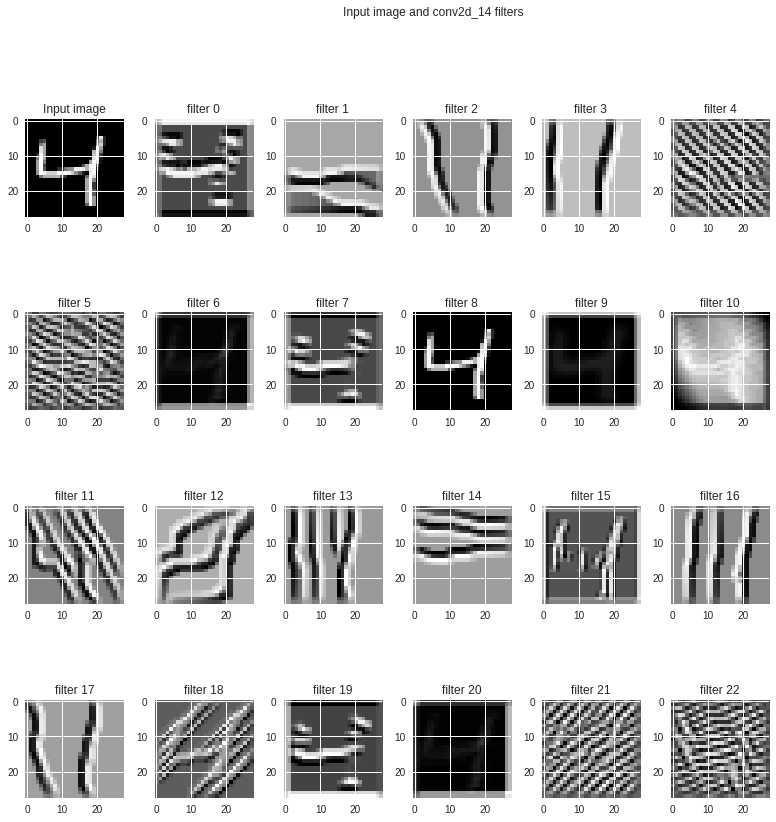

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
%matplotlib inline
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(X_train[2]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_14'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

vis_img_in_filter()